<a href="https://colab.research.google.com/github/connorpheraty/DS-Unit-2-Sprint-4-Practicing-Understanding/blob/master/Connor_Heraty_Model_Interpretation_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment - DS Unit 2  / Sprint 4 /  Module 3

## Loading and Feature Engineering

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

In [0]:
# Download and join data into a dataframe
def load(): 
    fremont_bridge = 'https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD'
    
    bicycle_weather = 'https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv'

    counts = pd.read_csv(fremont_bridge, index_col='Date', parse_dates=True, 
                         infer_datetime_format=True)

    weather = pd.read_csv(bicycle_weather, index_col='DATE', parse_dates=True, 
                          infer_datetime_format=True)

    daily = counts.resample('d').sum()
    daily['Total'] = daily.sum(axis=1)
    daily = daily[['Total']] # remove other columns

    weather_columns = ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND']
    daily = daily.join(weather[weather_columns], how='inner')
    
    # Make a feature for yesterday's total
    daily['Total_yesterday'] = daily.Total.shift(1)
    daily = daily.drop(index=daily.index[0])
    
    return daily

daily = load()

In [0]:
# Modified from code cells 17-21 at
# https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Example:-Predicting-Bicycle-Traffic

def jake_wrangle(X):  
    X = X.copy()

    # patterns of use generally vary from day to day; 
    # let's add binary columns that indicate the day of the week:
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    for i, day in enumerate(days):
        X[day] = (X.index.dayofweek == i).astype(float)


    # we might expect riders to behave differently on holidays; 
    # let's add an indicator of this as well:
    from pandas.tseries.holiday import USFederalHolidayCalendar
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays('2012', '2016')
    X = X.join(pd.Series(1, index=holidays, name='holiday'))
    X['holiday'].fillna(0, inplace=True)


    # We also might suspect that the hours of daylight would affect 
    # how many people ride; let's use the standard astronomical calculation 
    # to add this information:
    def hours_of_daylight(date, axis=23.44, latitude=47.61):
        """Compute the hours of daylight for the given date"""
        days = (date - pd.datetime(2000, 12, 21)).days
        m = (1. - np.tan(np.radians(latitude))
             * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
        return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

    X['daylight_hrs'] = list(map(hours_of_daylight, X.index))

    
    # temperatures are in 1/10 deg C; convert to C
    X['TMIN'] /= 10
    X['TMAX'] /= 10
    
    # We can also calcuate the average temperature.
    X['Temp (C)'] = 0.5 * (X['TMIN'] + X['TMAX'])

    # precip is in 1/10 mm; convert to inches
    X['PRCP'] /= 254

    # In addition to the inches of precipitation, let's add a flag that 
    # indicates whether a day is dry (has zero precipitation):
    X['dry day'] = (X['PRCP'] == 0).astype(int)


    # Let's add a counter that increases from day 1, and measures how many 
    # years have passed. This will let us measure any observed annual increase 
    # or decrease in daily crossings:
    X['annual'] = (X.index - X.index[0]).days / 365.

    return X

#X_train = jake_wrangle(X_train)
#X_test = jake_wrangle(X_test)
daily = jake_wrangle(daily)

In [0]:
# light rain = 0 - 0.10 PRCP
# Moderate rain = 0.10 - 0.30 PRCP
# Heavy rain = 0.30+
daily['light_rain'] = (daily['PRCP'] > 0) & (daily['PRCP'] < 0.10)
daily['moderate_rain'] = (daily['PRCP'] >= 0.1) & (daily['PRCP'] < 0.30)
daily['heavy_rain'] = (daily['PRCP'] >= 0.30)
daily['weekend_day'] = (daily['Sat']==1) | (daily['Sun'] == 1)

In [10]:
train = daily[:-100] # everything but the last 100 days
test  = daily[-100:] # last 100 days
train.shape, test.shape

((963, 24), (100, 24))

In [11]:
X_train = train.drop(columns='Total')
y_train = train['Total']

X_test  = test.drop(columns='Total')
y_test  = test['Total']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((963, 23), (963,), (100, 23), (100,))

## Fitting Data to Model

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

In [14]:
params= {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 4, 5, 6, None],
    'criterion' : ['mae'],
     
}

search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions = params,
    scoring='neg_mean_absolute_error',
    n_iter = 20,
    cv=3,
    n_jobs = -1,
    verbose=True,
    return_train_score=True
)

search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.7min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=20, n_jobs=-1,
          param_distributions={'n_estimators': [50, 100, 150, 200], 'max_depth': [3, 4, 5, 6, None], 'criterion': ['mae']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=True)

## Scoring Feature Importances

In [15]:
search.best_score_

-318.5964356178609

In [0]:
best = search.best_estimator_

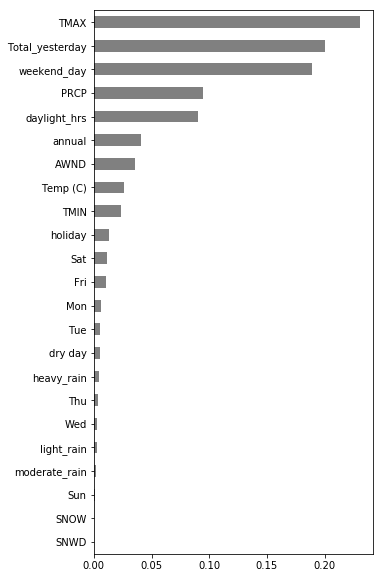

In [17]:
n = len(X_train.columns)
figsize = (5, 10)

importances = pd.Series(best.feature_importances_, X_train.columns)
top_n = importances.sort_values()[-n:]
plt.figure(figsize = figsize)
top_n.plot.barh(color='gray');

## Permutation Importance

In [19]:
!pip install eli5

     |████████████████████████████████| 102kB 2.8MB/s 


In [22]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(best, cv='prefit',
                                n_iter=2, random_state=42)

permuter.fit(X_test.values, y_test)

PermutationImportance(cv='prefit',
           estimator=RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
           n_iter=2, random_state=42, refit=True, scoring=None)

In [23]:
feature_names = X_test.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
1.0098 ± 0.0692,weekend_day
0.0975 ± 0.0136,Total_yesterday
0.0719 ± 0.0310,PRCP
0.0401 ± 0.0064,Fri
0.0353 ± 0.0119,TMAX
0.0345 ± 0.0069,Sat
0.0127 ± 0.0014,holiday
0.0114 ± 0.0096,daylight_hrs
0.0049 ± 0.0046,TMIN
0.0032 ± 0.0009,Tue


## Partial Dependence Plots

In [24]:
# Install pdpbox
!pip install pdpbox

     |████████████████████████████████| 57.7MB 1.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


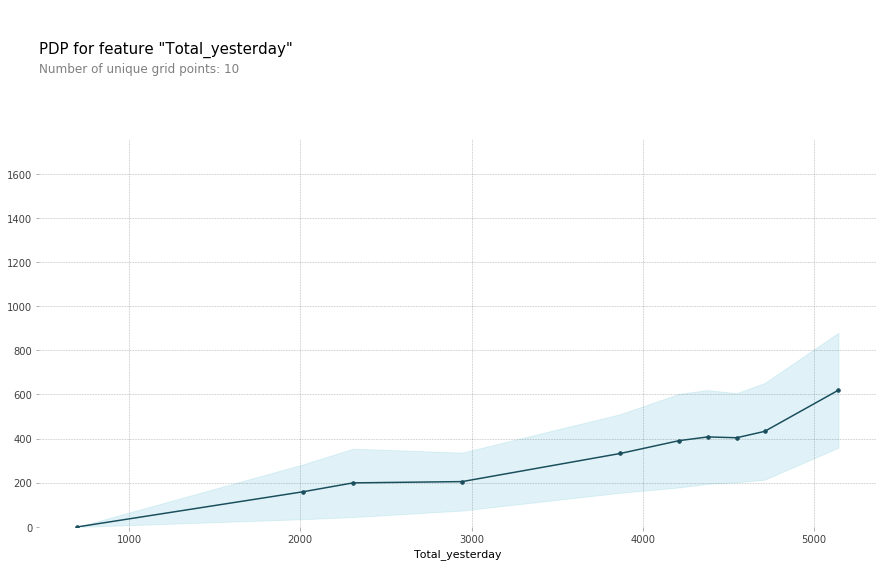

In [29]:
# Partial Dependence Plot
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Total_yesterday'

isolated = pdp_isolate(
    model = best,
    dataset=X_test,
    model_features=X_test.columns,
    feature = feature

)

pdp_plot(isolated, feature_name=feature);

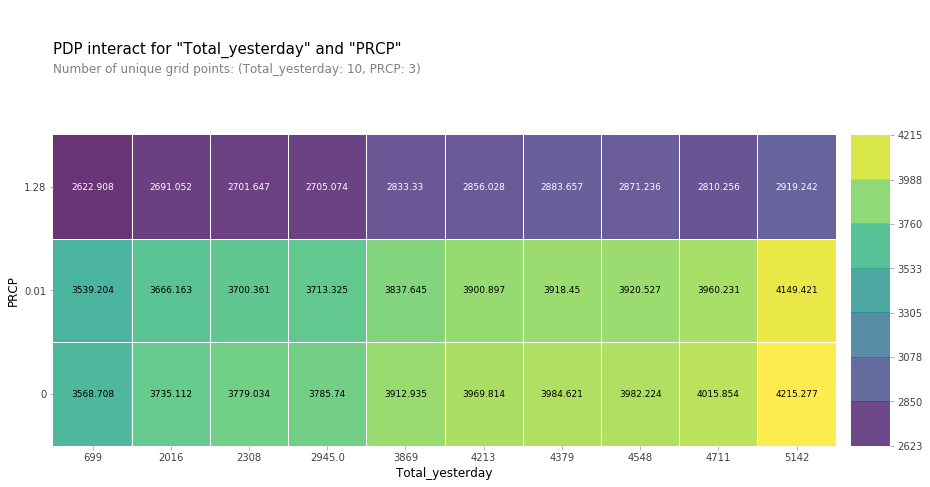

In [48]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['Total_yesterday', 'PRCP']


interaction = pdp_interact(
    model = best,
    dataset=X_test,
    model_features = X_test.columns,
    features = features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names = features, figsize = (15,8));

## Shapley Values

In [37]:
!pip install shap

     |████████████████████████████████| 225kB 2.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/bf/26/bd/912db1314f1cef0171d9b7f128dd01e8b8c92ed8d0062e632d
Successfully built shap


In [49]:
# Check for date to predict
X_test.head()

,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,Temp (C),dry day,annual,light_rain,moderate_rain,heavy_rain,weekend_day
2015-05-25,0.0,0,0,15.6,11.1,27,1776.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.269661,13.35,1,2.638356,False,False,False,False
2015-05-26,0.0,0,0,21.7,11.7,21,1737.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,15.303607,16.70,1,2.641096,False,False,False,False
2015-05-27,0.0,0,0,24.4,11.7,18,4254.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,15.336561,18.05,1,2.643836,False,False,False,False
2015-05-28,0.0,0,0,27.8,12.2,21,4771.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,15.368497,20.00,1,2.646575,False,False,False,False
2015-05-29,0.0,0,0,26.1,12.8,25,5142.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,15.399396,19.45,1,2.649315,False,False,False,False


In [45]:
data_for_prediction = X_test[X_test.index=='2015-05-30']
data_for_prediction

,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,Temp (C),dry day,annual,light_rain,moderate_rain,heavy_rain,weekend_day
2015-05-30,0.0,0,0,22.8,10.0,25,4548.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,15.429234,16.4,1,2.652055,False,False,False,True


In [46]:
# Shapley Plot
import shap
shap.initjs()
explainer = shap.TreeExplainer(best)
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

In [42]:
X_test.tail()

,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,Temp (C),dry day,annual,light_rain,moderate_rain,heavy_rain,weekend_day
2015-08-28,0.019685,0,0,23.3,15.6,26,4336.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,13.418591,19.45,0,2.898630,True,False,False,False
2015-08-29,1.279528,0,0,22.2,13.3,58,2653.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,13.362212,17.75,0,2.901370,False,False,True,True
2015-08-30,0.401575,0,0,20.0,12.8,47,699.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,13.305611,16.40,0,2.904110,False,False,True,True
2015-08-31,0.000000,0,0,18.9,16.1,58,1213.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.248802,17.50,1,2.906849,False,False,False,False
2015-09-01,0.228346,0,0,19.4,13.9,-9999,2823.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,13.191795,16.65,0,2.909589,False,True,False,False


In [43]:
data_for_prediction = X_test[X_test.index=='2015-05-28']
data_for_prediction

,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,Temp (C),dry day,annual,light_rain,moderate_rain,heavy_rain,weekend_day
2015-05-28,0.0,0,0,27.8,12.2,21,4771.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,15.368497,20.0,1,2.646575,False,False,False,False


In [44]:
shap.initjs()
explainer = shap.TreeExplainer(best)
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)